Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [9]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
train = train.replace({'functional': 0, 'non functional': 2, 'functional needs repair': 1})
# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [10]:
train, val = train_test_split(train, train_size=0.80,
                              test_size=0.20, stratify=train['status_group'], random_state=59)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [11]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
id,47520.0,37082.794129,21437.491933,1.000000,18453.750000,37016.500000,55606.250000,7.424700e+04
amount_tsh,47520.0,313.752218,3069.845924,0.000000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,47520.0,667.354840,693.577921,-63.000000,0.000000,366.000000,1319.000000,2.770000e+03
longitude,47520.0,34.056254,6.638606,0.000000,33.095244,34.909669,37.181618,4.034519e+01
latitude,47520.0,-5.706267,2.950456,-11.648378,-8.552624,-5.019629,-3.325156,-2.000000e-08
num_private,47520.0,0.505156,13.402425,0.000000,0.000000,0.000000,0.000000,1.776000e+03
region_code,47520.0,15.294297,17.621342,1.000000,5.000000,12.000000,17.000000,9.900000e+01
district_code,47520.0,5.628935,9.650772,0.000000,2.000000,3.000000,5.000000,8.000000e+01
population,47520.0,178.728577,449.592256,0.000000,0.000000,25.000000,214.000000,1.530000e+04
construction_year,47520.0,1299.831629,951.894479,0.000000,0.000000,1986.000000,2004.000000,2.013000e+03


In [12]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44869,2,True,40819
permit,45073,2,True,31135
source_class,47520,3,groundwater,36611
management_group,47520,5,user-group,42006
quantity_group,47520,5,enough,26519
quantity,47520,5,enough,26519
waterpoint_type_group,47520,6,communal standpipe,27739
quality_group,47520,6,good,40714
payment_type,47520,7,never pay,20239


In [13]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning (in acordince with lectuere)
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # replace the zeros with nulls.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    cols_with_zeros = ['population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    cols_with_zeros = ['construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    cols_with_zeros = ['amount_tsh']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # duplicates, so drop them
    X = X.drop(columns='quantity')
    X = X.drop(columns='quality_group')
    X = X.drop(columns='waterpoint_type_group')
    X = X.drop(columns='extraction_type_group')
    X = X.drop(columns='extraction_type_class')
    X = X.drop(columns='payment')
    X = X.drop(columns='source_type')
    X = X.drop(columns='scheme_management')
    # 
    X['year_inspected'] = pd.DatetimeIndex(X['date_recorded']).year
    X['years_since_inspection'] = X['year_inspected'] - X['construction_year']
    X = X.drop(columns='year_inspected')
    
    X['Permited_and_Public'] = X['public_meeting'] & X['permit']
    
      # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# creating target and features lsts
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'years_since_inspection', 'basin', 'region', 'public_meeting', 'recorded_by', 'permit', 'extraction_type', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type', 'Permited_and_Public']


In [48]:
# creating Train, Validation, and Test vars
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=413, random_state=63,
                           n_jobs=-1, min_samples_split=4)
)

# Fit on train, score on val
#pipeline.fit(X_train, y_train)
#print('Validation Accuracy', pipeline.score(X_val, y_val))
k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)

MAE for 3 folds: [0.32981947 0.33436454 0.32672517]
Validation Accuracy 0.8145622895622896


In [52]:
# estimator is your model or pipeline, which you've fit on X_train
 
# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train
 
y_pred = pipeline.predict(X_test)
 
# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
#train = train.replace({'functional': 0, 'non functional': 2, 'functional needs repair': 1})

sample_submission = sample_submission.copy()
sample_submission['status_group'] = y_pred
sample_submission['status_group'] = sample_submission['status_group'].replace({0:'functional', 2:'non functional', 1:'functional needs repair'})
sample_submission.to_csv('riley_base.csv', index=False)

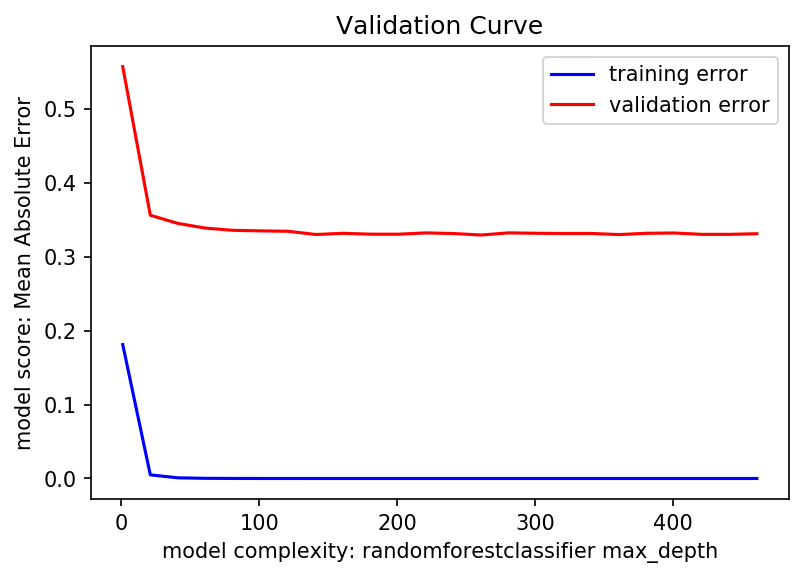

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier()
)

depth = range(1, 480, 20)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__n_estimators', 
    param_range=depth, scoring='neg_mean_absolute_error', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: randomforestclassifier max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend();

In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__min_samples_split': [2, 4, 6, 8],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4],
    'randomforestclassifier__max_features': uniform(0, 1), 
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  2.4min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.3min remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished


Best hyperparameters {'randomforestclassifier__max_features': 0.1998816031845072, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__n_estimators': 174, 'simpleimputer__strategy': 'median'}
Cross-validation MAE 0.33005050505050504


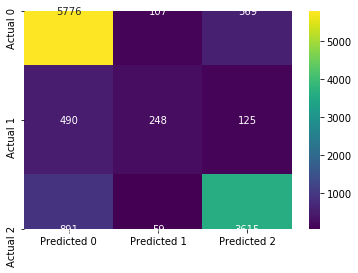

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted 0,Predicted 1,Predicted 2
Actual 0,5776,107,569
Actual 1,490,248,125
Actual 2,891,59,3615


In [ ]:
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
    'targetencoder__smoothing': uniform(1, 1000), 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)